# 权重衰减

权重衰减是最广泛使用的正则化的技术之一

In [1]:
import sys
sys.path.append('..')

我们通过一个简单的例子来演示权重衰减

In [2]:
%matplotlib inline
from d2l import mindspore as d2l
import mindspore as ms
from mindspore import nn, ops, value_and_grad

像以前一样生成一些数据
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = d2l.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [ ]:
def init_params():
    w = Parameter(d2l.normal((num_inputs, 1), 0, 1))
    b = Parameter(ops.zeros(1))
    return [w, b]

定义$L_2$范数惩罚

In [4]:
def l2_penalty(w):
    return ms.sum(ops.pow(w, 2)) / 2

定义训练代码实现

In [5]:
from mindspore import Parameter
from mindspore.common.initializer import initializer, Normal, Zero

class Net(nn.Cell):
    def __init__(self, num_inputs, lambd=0):
        super().__init__()
        self.w = Parameter(initializer(Normal(1, 0), (num_inputs, 1), mindspore.float32))
        self.b = Parameter(initializer(Zero(), (1,), mindspore.float32))
        self.lambd = lambd

    def construct(self, x, y):
        y_hat = d2l.linreg(x, self.w, self.b)
        loss = d2l.squared_loss(y_hat, y)
        if self.training:
            loss += self.lambd * l2_penalty(self.w)
        return loss

定义训练代码实现

In [6]:
import mindspore.numpy as mnp

def train(lambd):
    w, b = init_params()
    net, loss_fn = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    optim = d2l.SGD(lr, batch_size, [w, b])
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    # 定义前向传播函数
    def forward_fn(x, y):
        z = net(x)
        loss = loss_fn(z, y).mean()
        return loss

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, weights=[w, b])

    # 定义模型单步训练
    def train_one_step(X, Y):
        loss, grads = grad_fn(X, Y)
        loss += lambd * l2_penalty(w)
        loss = ops.depend(loss, optim(grads))
        return loss

    for epoch in range(num_epochs):
        for X, y in train_iter.create_tuple_iterator():
            l = train_one_step(X, y)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, l),
                                     d2l.evaluate_loss(net, test_iter, l)))
    print('w的L2范数是：', ops.norm(w).asnumpy())

忽略正则化直接训练

w的L2范数是： 12.237418


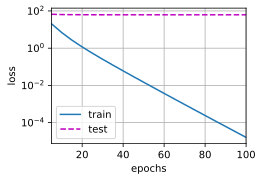

In [7]:
from mindspore import context
train(lambd=0)

使用权重衰减

w的L2范数是： 0.38045686


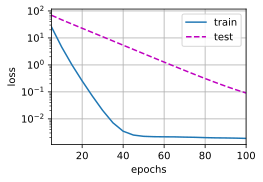

In [8]:
train(lambd=3)

简洁实现

In [9]:
def train_concise(wd):
    net = nn.SequentialCell(nn.Dense(num_inputs, 1, weight_init=Normal(1, 0)))
    loss_fn = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # mindspore的SGD不支持对单个parameter做weight_decay
    optim = nn.SGD(net.trainable_params(), learning_rate=lr, weight_decay=wd)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    # 定义前向传播函数
    def forward_fn(x, y):
        z = net(x)
        loss = loss_fn(z, y).mean()
        return loss

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, weights=net.trainable_params())

    # 定义模型单步训练
    def train_one_step(X, Y):
        loss, grads = grad_fn(X, Y)
        loss = ops.depend(loss, optim(grads))
        return loss

    for epoch in range(num_epochs):
        for X, y in train_iter.create_tuple_iterator():
            l = train_one_step(X, y)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, l),
                                     d2l.evaluate_loss(net, test_iter, l)))
    print('w的L2范数：', ops.norm(net[0].weight).asnumpy())

这些图看起来和我们从零开始实现权重衰减时的图相同

w的L2范数： 13.939608


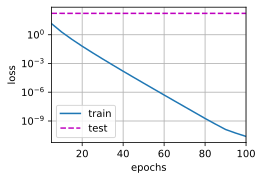

In [10]:
train_concise(0)

w的L2范数： 0.35746962


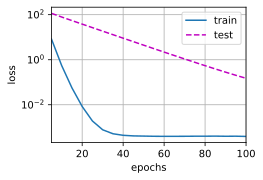

In [11]:
train_concise(3)